# The Hawk-Dove Game

We have learned how phenotypic diversity within a population can serve as a bet-hedging strategy for adaptation in a randomly changing environment. In other cases, phenotypic diversity can arise due to competition between individuals in the same population. Common examples include male dimorphism in many species, where individuals develop different morphologies that allow them to use alternative reproductive tactics, such as beetles that either develop a big horn to guard their nests or resemble hornless females to sneak into others' nests. The phenotypic differences can also be in the behavior, e.g., some individuals are more aggressive and tend to fight off intruders while others are more submissive and tend to yield.

Although animals commonly fight for resources, terratories, or mates, it is observed that most fights are "ritualized" -- the opponents use calls or displays to intimidate each other until one concedes, without escalating to direct fights that can cause serious injuries. Intuitively, one can argue that because these individuals are part of the same species, having too many injuries would be bad for the species as a whole, so fighting should be limited. However, this argument does not explain the incentive from each individual's perspective. In order to analyze the motivation behind each individual's behavior, we will adopt some formalism from game theory.

## Two-player symmetric games

Imagine that individuals of the population randomly encounter one another to carry out repeated pairwise competitions. In a competition ("game"), each participant can choose from a set of actions. For simplicity, we assume that there is only one round of competition between the two participants. The outcome of the competition will be determined by the actions they choose, and will be represented by the "payoff" that each receives. We will focus on the symmetric case where the set of actions is the same for both participants, labeled by $i = 0, 1, \cdots$ Such a two-player symmetric game can be represented by a "payoff matrix" $v_{ij}$, where each entry quantifies the payoff of one participant when it chooses action $i$ while the opponent chooses action $j$. (We only need to know the payoff of one participant because, by symmetry, the payoff of the other participant will be $v_{ji}$.) This payoff matrix is similar to the fitness matrix that we used in studying bet-hedging before. One can think of the situation there as the organisms playing a game against the changing environment (so the game is not symmetric but we only care about the payoff of the organisms).

We can distinguish between two scenarios. In one scenario, the population is formed by individuals that each consistently uses one and the same action. In this case each individual is said to be using a "pure strategy", and the population can be a mixture ("polymorphism") of different types of individuals. In the second scenario, each individual chooses actions randomly according to some probability distribution, and all individuals use the same probability distribution. In this case the individuals are said to be using a "mixed" strategy, but the population is considered to be homogeneous because all individuals use the same strategy. These two scenarios are very similar when we focus on one individual (the "player") that will repeatedly encounter randomly chosen opponents from the population. Let $p_j$ be the probability that its opponent will choose action $j$. This probability would be equal to the composition of the population in the first scenario, or the mixed strategy that everyone else uses in the second scenario. We will let the player use a mixed strategy $q_i$, which is not necessarily the same as $p_i$. This is because we want to study whether a strategy is stable, i.e., whether the player has an incentive to deviate from the "resident" strategy $p$ so as to increase its own payoff.

Let us first examine how the player's payoff accumulates over time. We will write a Python class to simulate a generic two-player symmetric game that is repeated many times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SymmetricGame:
    """
    simulate a repeated two-player symmetric game.
    """
    
    def __init__(self, opp_dist, pay_mat, record=True):
        """
        initialize game.
        inputs:
        opp_dist: 1-d array-like, probability distribution p_j for mixed strategy used by opponent.
        pay_mat: 2-d array-like, payoff matrix v[i,j] = payoff when self plays i and opponent plays j.
        record: bool, whether to record history of the plays.
        """
        self.opp_dist = np.asarray(opp_dist)    # opponent distribution p_i
        self.pay_mat = np.asarray(pay_mat)    # payoff matrix v_{ij}
        self.reward = 0    # current amount of rewards accumulated
        self.time = 0    # current number of rounds played
        self.record = record
        if record:
            self.play_hist = []    # history of both players' choices
            self.reward_hist = []    # history of accumulated rewards
    
    def play(self, own_dist, T):
        """
        simulate repeated games.
        inputs:
        own_dist: 1-d array-like, probability distribution q_i for mixed strategy used by self.
        T: int, number of rounds to play.
        """
        opp_seq = np.random.choice(self.pay_mat.shape[1], size=T, p=self.opp_dist)    # draw random plays by opponent
        own_seq = np.random.choice(self.pay_mat.shape[0], size=T, p=own_dist)    # draw random plays by self
        for t in range(T):
            opp = opp_seq[t]
            own = own_seq[t]
            self.reward = self.reward + self.pay_mat[own,opp]
            if self.record:    # record history
                self.play_hist.append([own, opp])
                self.reward_hist.append(self.reward)

## Hawk-Dove game

We will consider a specific game introduced by (Smith & Price 1973) to study animal conflicts, which is known as the "Hawk-Dove" game in biology. Here "Hawk" and "Dove" are not referring to two different species, but rather two behaviors that can be adopted by individuals of a population. In a competition, if one individual plays Hawk and the other plays Dove, then the Hawk wins and takes a reward $V$ while the Dove leaves without a reward. If both play Dove, then they split the reward and takes $V/2$ each. However, if both play Hawk, there will be a fight, and even though each has a 50% chance of winning the reward $V$, there will be a cost $C$ associated with potential injuries. Thus, the payoff matrix is parametrized by: 

|      | Hawk | Dove |
| :--- | :---: | :---: |
| **Hawk** | $\frac{V-C}{2}$ | $V$ |
| **Dove** | $0$ | $\frac{V}{2}$ |

Here the entries are the player's payoffs; the rows represent the player's actions, whereas the columns represent the opponent's actions. We are interested in the case where $C > V > 0$. In this case, if the opponent plays Hawk, then it is more beneficial for the player to play Dove; on the other hand, if the opponent plays Dove, then the player benefits more by playing Hawk. Therefore, neither of the actions is a dominant play, i.e., being better in all situations. In such cases, we expect that the "equilibrium" will be a mixed strategy, as studied below.

Let us first make a simulation of the Hawk-Dove game. This is done by defining a derived class with the specific payoff matrix.

In [3]:
class HawkDove(SymmetricGame):
    """
    simulate the hawk-dove game.
    """
    
    def __init__(self, V, C, opp_dist, record=True):
        """
        initialize game.
        inputs:
        V: float, reward from winning the game.
        C: float, cost of losing the game.
        opp_dist: 1-d array-like, probability distribution p_j for mixed strategy used by opponent.
        record: bool, whether to record history of the plays.
        """
        pay_mat = [[(V-C)/2, V], [0, V/2]]
        SymmetricGame.__init__(self, opp_dist, pay_mat, record)

We will use the following parameter values.

In [4]:
V = 1    # reward if one wins the competition
C = 2    # cost due to potential injuries, C > V

To test-run the game, we will arbitrarily choose some probability distributions as mixed strategies for both participants.

In [5]:
opp_dist = [0.7, 0.3]    # opponent's strategy
own_dist = [0.2, 0.8]    # player's own strategy

T = 1000    # number of rounds to play

hd1 = HawkDove(V, C, opp_dist)    # create a game with given opponent's strategy
hd1.play(own_dist, T)    # play the game for `T` rounds with own strategy

Let us plot the reward history to see how it accumulates over time. The average reward rate can be calculated as:
\begin{equation}
W_T = \frac{1}{T} \big( N_T - N_0 \big)
\end{equation}
where $N_0$ is the initial amount of reward (set to 0) and $N_T$ is the accumulated reward after $T$ rounds. The expected reward rate can be found as:
\begin{equation}
W = \lim_{T\to\infty} W_T = \sum_i p_i \Big( \sum_j q_j v_{ji} \Big)
\end{equation}
Notice how similar the expression looks to the formula for the long-term growth rate in bet-hedging, the only difference being that the latter has a `log` outside the brackets (in other words, it is a geometric mean there, but an arithmetic mean here).

In [6]:
W_avg = hd1.reward / T    # average reward rate
W_thr = np.dot(own_dist, np.dot(hd1.pay_mat, hd1.opp_dist))    # theoretical reward rate

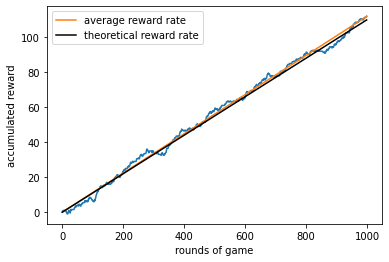

In [7]:
plt.figure()
plt.plot(hd1.reward_hist)    # plot reward history
plt.plot(W_avg*np.arange(T), label='average reward rate')    # plot average growth
plt.plot(W_thr*np.arange(T), 'k', label='theoretical reward rate')    # plot theoretical growth
plt.xlabel('rounds of game')
plt.ylabel('accumulated reward')
plt.legend()
plt.show()

It can be seen that we are indeed accumulating rewards. But is this the best we can do? To find out, let us vary our strategy $q$ and repeat the calculation above to see which strategy is optimal.

In [8]:
qH_list = np.arange(0.005, 1, 0.01)    # list of own strategies (probability of Hawk)
W_avg_list = []    # list to save average reward rates
W_thr_list = []    # list to save theoretical reward rates

T = 10000    # rounds to play

for qH in qH_list:
    own_dist = [qH, 1-qH]
    hd1 = HawkDove(V, C, opp_dist)
    hd1.play(own_dist, T)
    W_avg = hd1.reward / T    # average reward rate
    W_thr = np.dot(own_dist, np.dot(hd1.pay_mat, hd1.opp_dist))    # theoretical reward rate
    W_avg_list.append(W_avg)
    W_thr_list.append(W_thr)

Let us plot the reward rate as a function of our strategy.

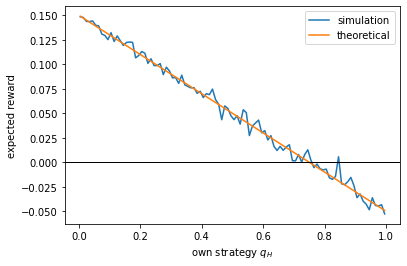

In [9]:
plt.figure()
plt.plot(qH_list, W_avg_list, label='simulation')    # average reward rate
plt.plot(qH_list, W_thr_list, label='theoretical')    # theoretical reward rate
plt.axhline(0, color='k', lw=1)
plt.xlabel(r'own strategy $q_H$')
plt.ylabel('expected reward')
plt.legend()
plt.show()

It can be seen that, for the particular strategy that the opponent is using (70% Hawk and 30% Dove), the best strategy for the player would be to play Hawk with zero probability, i.e., to always play Dove.

To understand what this implies for the population, consider the first scenario where the population is composed of Hawks and Doves according to the distribution $p$. Our results above shows that, given how everyone else is playing currently, each individual has an incentive to play Dove in order to maximum its expected reward. Thus, as some individuals switch from playing Hawk to Dove, the percentage of Doves in the population will increase. On the other hand, when Doves become the majority in the population (e.g., $p = [0.3, 0.7]$), you may repeat the above calculations to find that the best strategy becomes always playing Hawk, which will then lead to a decrease of Doves. These trends suggest that there should be an equilibrium point in the middle, which we explore below.

## Equilibrium and stability

To find the equilibrium composition of the population, let us calculate the expected rewards from playing Hawk and Dove, respectively. When the current composition of the population is $(p, 1-p)$, the expected rewards are:
\begin{align}
W_H(p) &= p \, \frac{V-C}{2} + (1-p) \, V \\
W_D(p) &= p \cdot 0 + (1-p) \, \frac{V}{2}
\end{align}

Let us plot these as functions of $p$.

In [10]:
pH_array = np.linspace(0, 1, 101)
WH_array = pH_array * (V-C)/2 + (1 - pH_array) * V
WD_array = (1 - pH_array) * V/2

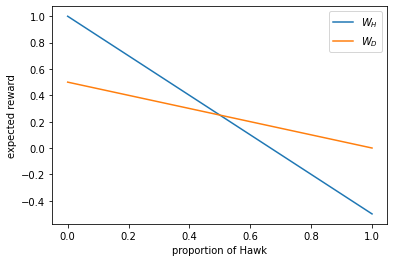

In [11]:
plt.figure()
plt.plot(pH_array, WH_array, label='$W_H$')
plt.plot(pH_array, WD_array, label='$W_D$')
plt.xlabel('proportion of Hawk')
plt.ylabel('expected reward')
plt.legend()
plt.show()

It can be seen that the two lines cross in the middle. Setting $W_H = W_D$ yields the solution $p^* = V/C$. When $p > p^*$, we have $W_D > W_H$, so more individuals should play Dove, making $p$ decrease; but when $p < p^*$, we have $W_H > W_D$, so individuals should switch to playing Hawk and cause $p$ to increase. Therefore, $p^*$ will be the equilibrium composition of the population.

### Nash Equilibrium

Let us now consider the second scenario where all individuals use the same mixed strategy $p$. In this case, an equilibrium can be defined by the condition that no one has incentive to deviate from the strategy. Suppose one individual attempts to use a different strategy $q$, which would give it an expected reward $W(q;p)$. Then the condition for a strategy $p^*$ to be a **Nash equilibrium** (NE) can be expressed as:
\begin{equation}
W(q;p^*) \leq W(p^*;p^*)
\end{equation}

Let us check that $p^* = V/C$ is a Nash equilibrium for the Hawk-Dove game. For this we will assume that everyone else in the (large) population is using the strategy $p^*$, and calculate the expected reward of a "mutant" individual that uses $q \neq p^*$.

In [12]:
pH_eq = V/C    # equilibrium fraction of hawks
print(f'equilibrium fraction of hawks = {pH_eq}')

equilibrium fraction of hawks = 0.5


In [13]:
opp_dist = [pH_eq, 1-pH_eq]

qH_list = np.arange(0.005, 1, 0.01)    # list of own strategies
W_avg_list = []    # list to save average reward rate
W_thr_list = []    # list to save theoretical reward rate

T = 10000
for qH in qH_list:
    own_dist = [qH, 1-qH]
    hd1 = HawkDove(V, C, opp_dist)
    hd1.play(own_dist, T)
    W_avg = hd1.reward / T
    W_thr = np.dot(own_dist, np.dot(hd1.pay_mat, hd1.opp_dist))
    W_avg_list.append(W_avg)
    W_thr_list.append(W_thr)

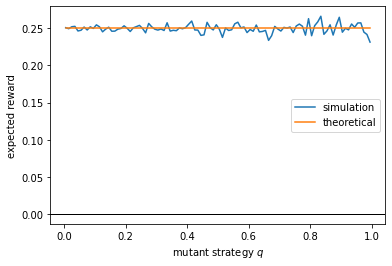

In [14]:
plt.figure()
plt.plot(qH_list, W_avg_list, label='simulation')    # plot average reward rate
plt.plot(qH_list, W_thr_list, label='theoretical')    # plot theoretical reward rate
plt.axhline(0, color='k', lw=1)
plt.xlabel(r'mutant strategy $q$')
plt.ylabel('expected reward')
plt.legend()
plt.show()

We see that, no matter what strategy the mutant uses, the expected reward is always the same. Therefore, it has no incentive to deviate from playing the same strategy $p^*$ as others. This proves that $p^*$ is a NE.

### Evolutionarily Stable Strategy

However, you might wonder that, since using a different strategy also does not hurt the mutant, this equilibrium is only "marginally stable" as nothing stops an individual from "drifting away" from the strategy $p^*$. In biological terms, if a mutant using a different strategy $q$ arises in the population, can it spread in the population by chance and take over the population? It turns out that this would not happen in our case, because $p^*$ satisfies a stronger equilibrium condition, known as an **evolutionarily stable strategy** (ESS) in biology. This condition requires that, if the mutants somehow become the majority of the population, then the original strategy $p^*$ will be more favorable than $q$ and thus stop the mutants from taking over. Mathematically, it means either $W(q;p^*) < W(p^*;p^*)$ (which makes $p^*$ a "strict" Nash equilibrium) or, in case $W(q;p^*) = W(p^*;p^*)$, then $p^*$ must further satisfy:
\begin{equation}
W(q;q) < W(p^*;q)
\end{equation}
Note that the conditions for ESS is stronger than NE, so an ESS is always a NE, but not the other way round.

Let us prove that $p^* = V/C$ is indeed an ESS for the Hawk-Dove game. To show this, let us calculate the function $W(q;p)$ for all $p$ and $q$.

In [15]:
pH_list = np.arange(0.005, 1, 0.01)    # list of opponent's strategies
qH_list = np.arange(0.005, 1, 0.01)    # list of player's own strategies
W_avg_array = np.zeros((len(pH_list), len(qH_list)))    # list to collect average growth rates
W_thr_array = np.zeros((len(pH_list), len(qH_list)))    # list to collect theoretical growth rates

for i in range(len(pH_list)):
    for j in range(len(qH_list)):
        opp_dist = [pH_list[i], 1-pH_list[i]]
        own_dist = [qH_list[j], 1-qH_list[j]]
        hd1 = HawkDove(V, C, opp_dist)
        T = 1000
        hd1.play(own_dist, T)
        W_avg = hd1.reward / T
        W_thr = np.dot(own_dist, np.dot(hd1.pay_mat, opp_dist))
        W_avg_array[i,j] = W_avg
        W_thr_array[i,j] = W_thr

We can plot $W(q;p)$ as a heatmap. Here we will only use the theoretical values.

In [16]:
plt.figure(figsize=(8,6))
plt.imshow(W_thr_array, origin='lower', extent=(0,1,0,1))    # plot W(q;p)
plt.axhline(pH_eq, color='r', lw=1)    # plot W(q;p^*)
plt.axvline(pH_eq, color='g', lw=1)    # plot W(p^*;q)
plt.plot([0,1], [0,1], color='b', lw=1)    # plot W(q;q)
plt.ylabel(r'opponent strategy $p_H$')
plt.xlabel(r'own strategy $q_H$')
plt.colorbar(label='expected reward')
plt.show()

The value of expected reward along the red line is $W(q;p^*)$ for different $q$, which is constant as we found above, proving that $p^*$ is a Nash equilibrium. The additional condition for ESS can be shown by comparing values along the green and blue lines. For every $q$ value (vertical position), $W(q;q)$ (point on the blue line) is always less than $W(p^*;q)$ (point on the green line), thus proving that $p^*$ is an evolutionarily stable strategy.

The fact that the equilibrium $p^*$ is a mixed strategy helps us understand the "limited war" type of animal conflicts in nature. Indeed, the model predicts that a direct fight between two individuals would only occur with probability $(p^*)^2 = V^2/C^2$, which is much less than $1$ if the cost of injuries is high. This "evolutionary game" model can be generalized to more sophisticated strategies, such as accounting for dependence on body size and assessment of fighting abilities, which turn out to further reduce fighting probabilities.